In [12]:
import torchaudio
from IPython.display import Audio
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
from helpers.path_utils import get_base_dir
from helpers.transform import TrimAfterTrigger, min_max_scale
from helpers.plot import plot_wavelet_spectrogram, plot_audio_fft

Sample rate:  4000


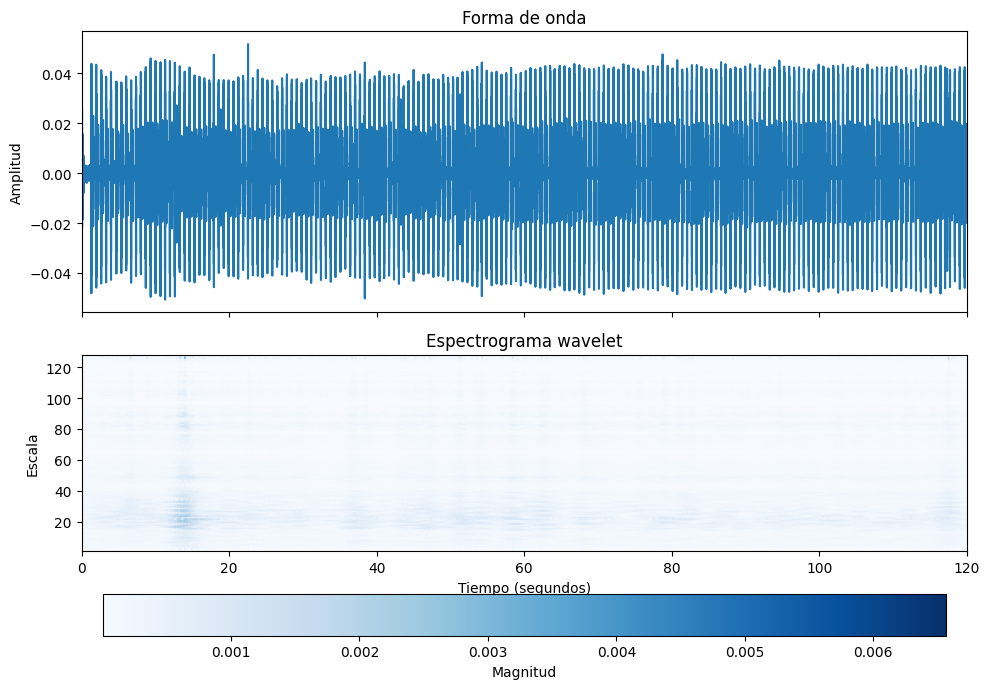

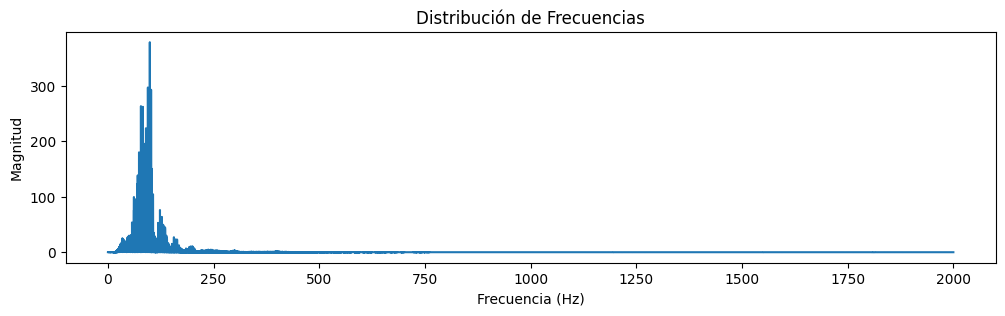

In [2]:
AUDIO_NAME = "SAM-Normal Heart Sounds 90 BPM.wav"

audio_dir = get_base_dir().joinpath("data", "stethos", "SAM", AUDIO_NAME)

audio, sample_rate = torchaudio.load(str(audio_dir))
print("Sample rate: ", sample_rate)

plot_wavelet_spectrogram(audio.numpy(), sample_rate)#, downsample_factor=1)
plot_audio_fft(audio.numpy(), sample_rate)

Audio(audio, rate=sample_rate, autoplay=True)

# Snippet to detect hearbeats

In [3]:
SECS = 6
cut_on = SECS*sample_rate
snippet = audio[:, :cut_on].clone()
audio.shape, snippet.shape

(torch.Size([1, 480000]), torch.Size([1, 24000]))

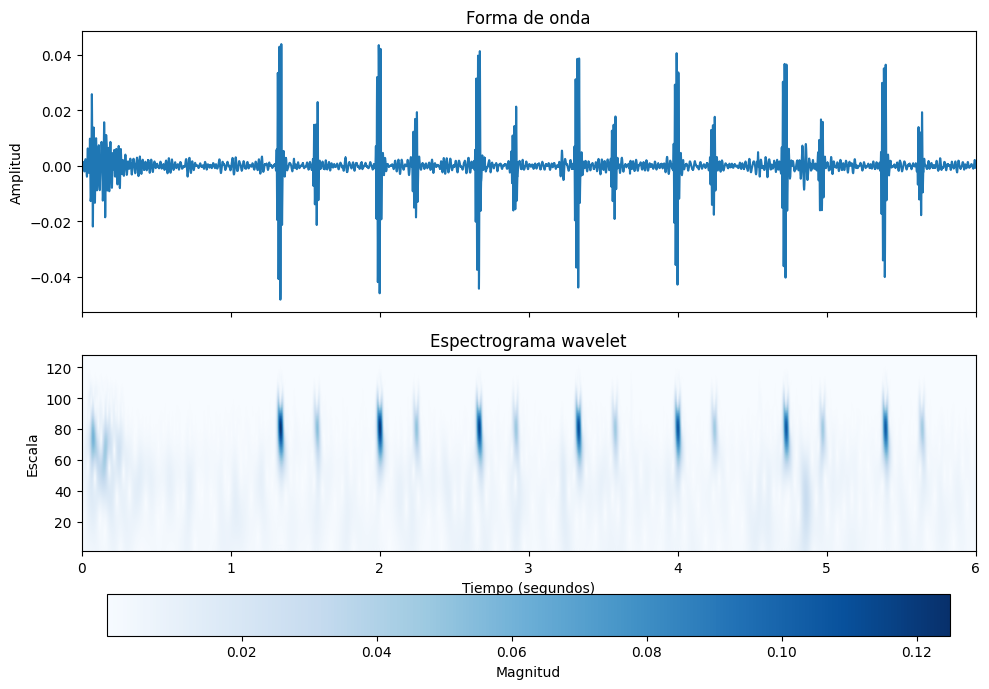

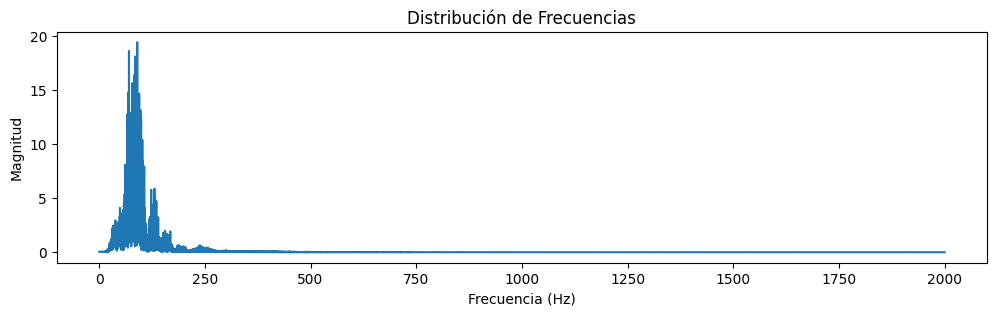

In [4]:
plot_wavelet_spectrogram(snippet, sample_rate, downsample_factor=1)
plot_audio_fft(snippet.numpy(), sample_rate)

Audio(snippet, rate=sample_rate, autoplay=True)

# TrimAfterTrigger class
We can use some methods of that class to detect heartbeats

In [5]:
tat = TrimAfterTrigger()
tat

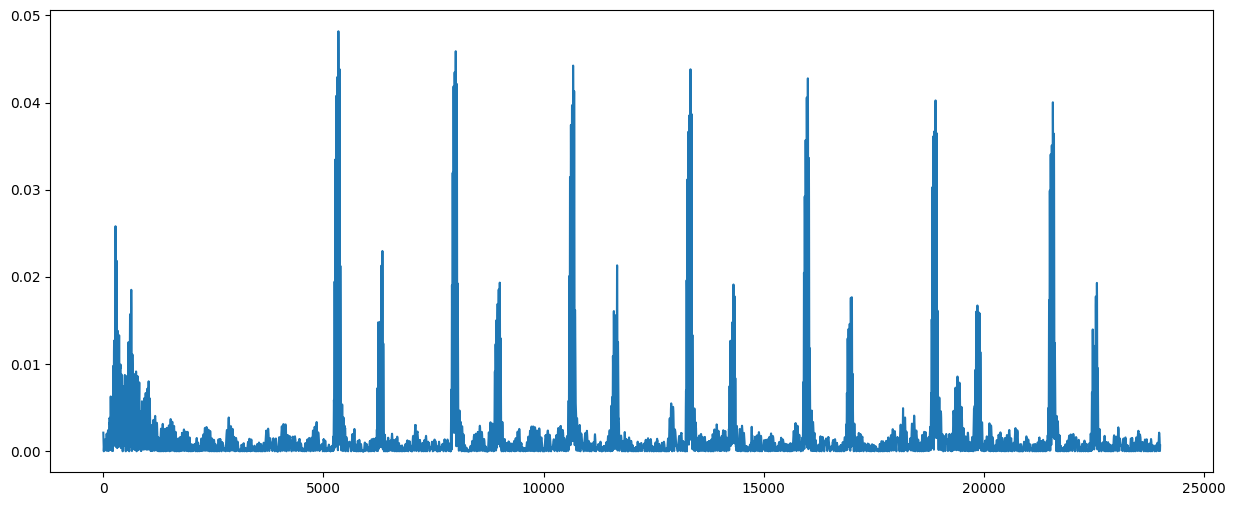

In [6]:
abs_snippet = tat.audio_to_abs(snippet)
plt.figure(figsize=(15, 6))
plt.plot(abs_snippet.squeeze())

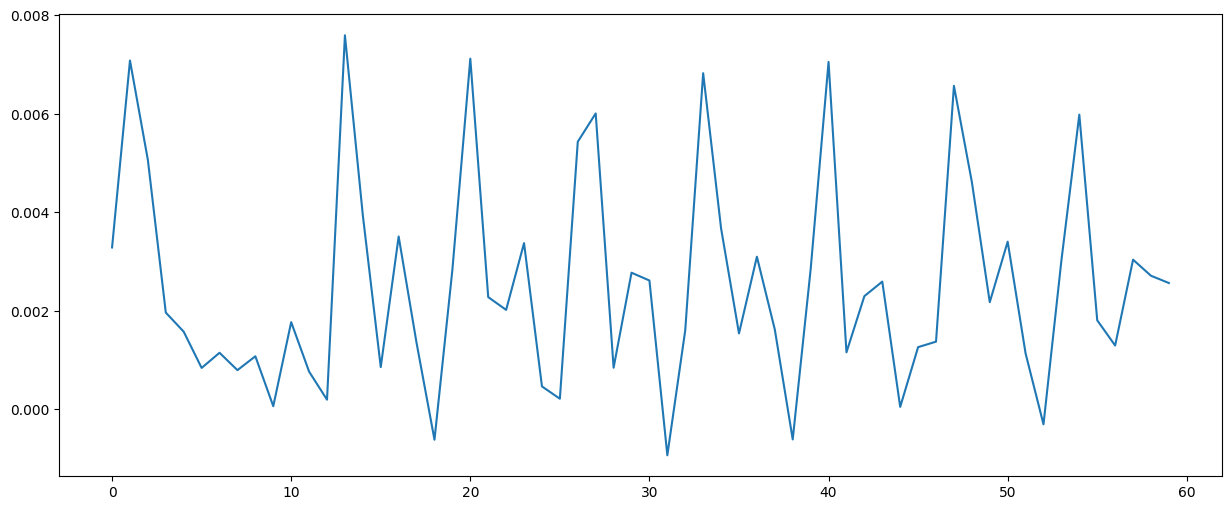

In [7]:
DOWNSAMPLE_FACTOR = 400
downsampled = tat.downsample_audio(abs_snippet, DOWNSAMPLE_FACTOR)

plt.figure(figsize=(15, 6))
plt.plot(downsampled.squeeze())

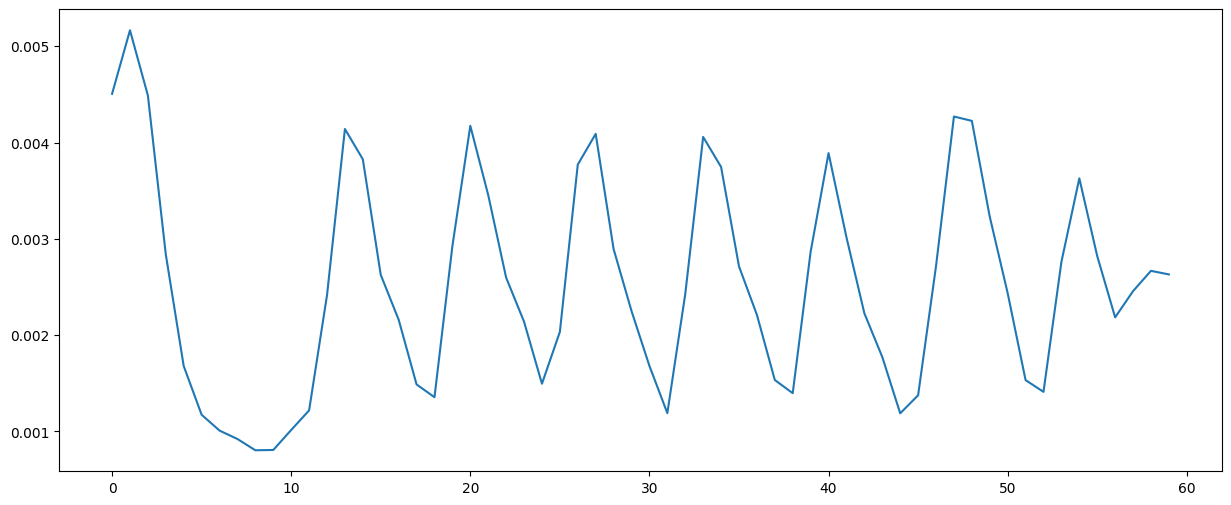

In [8]:
SIGMA_SMOOTH = 1
smoothed = tat.smooth_signal(downsampled, SIGMA_SMOOTH)

plt.figure(figsize=(15, 6))
plt.plot(smoothed.squeeze())

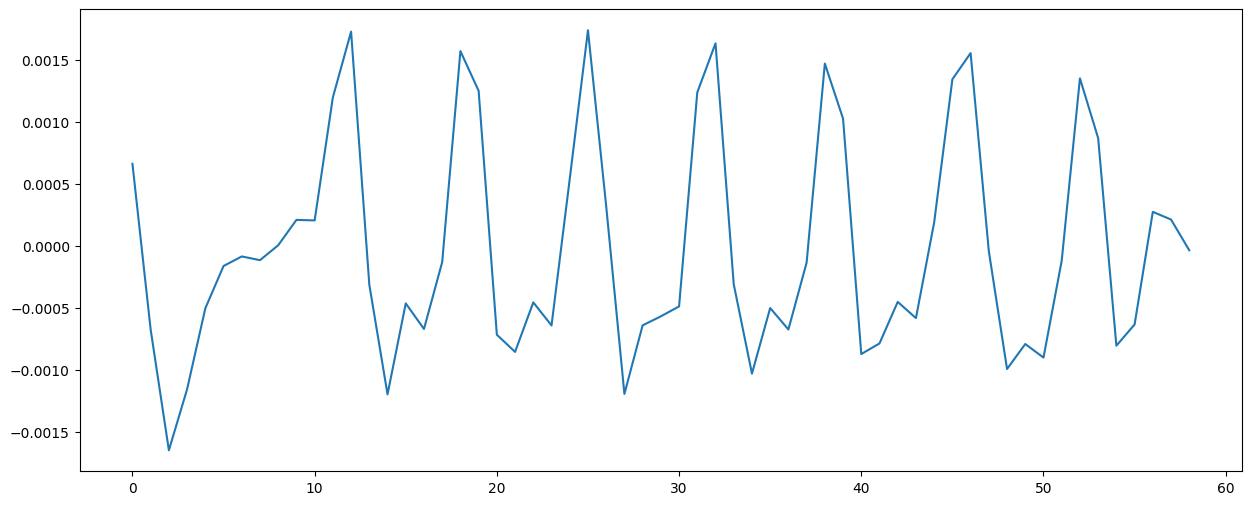

In [9]:
curve_diff = tat.signal_diff(smoothed)

plt.figure(figsize=(15, 6))
plt.plot(curve_diff.squeeze())

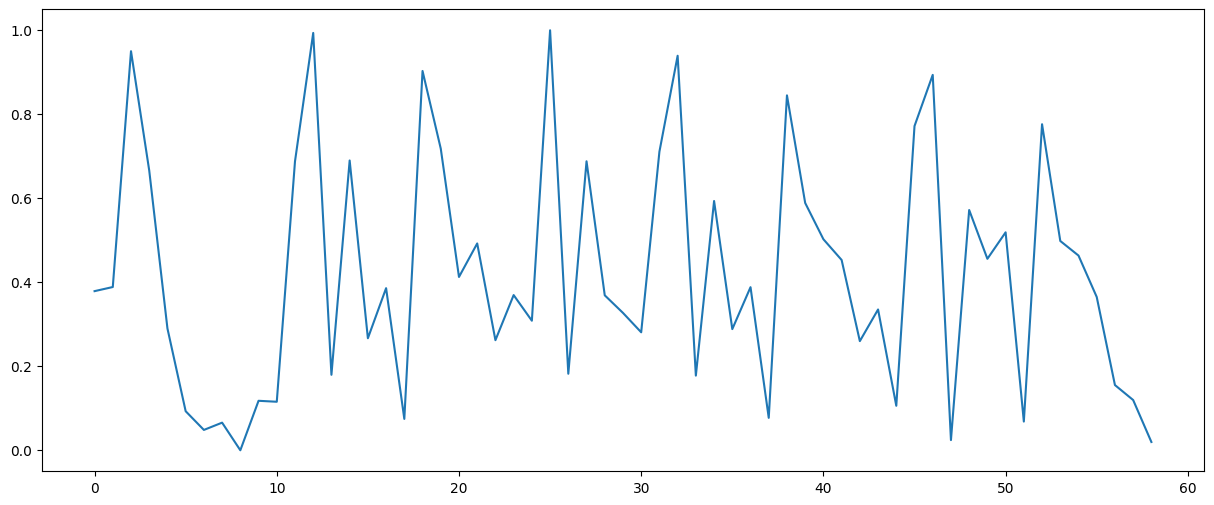

In [10]:
abs_diff = tat.audio_to_abs(curve_diff)
scaled_diff = tat.scale_audio(abs_diff, scaler=min_max_scale)

plt.figure(figsize=(15, 6))
plt.plot(scaled_diff.squeeze())

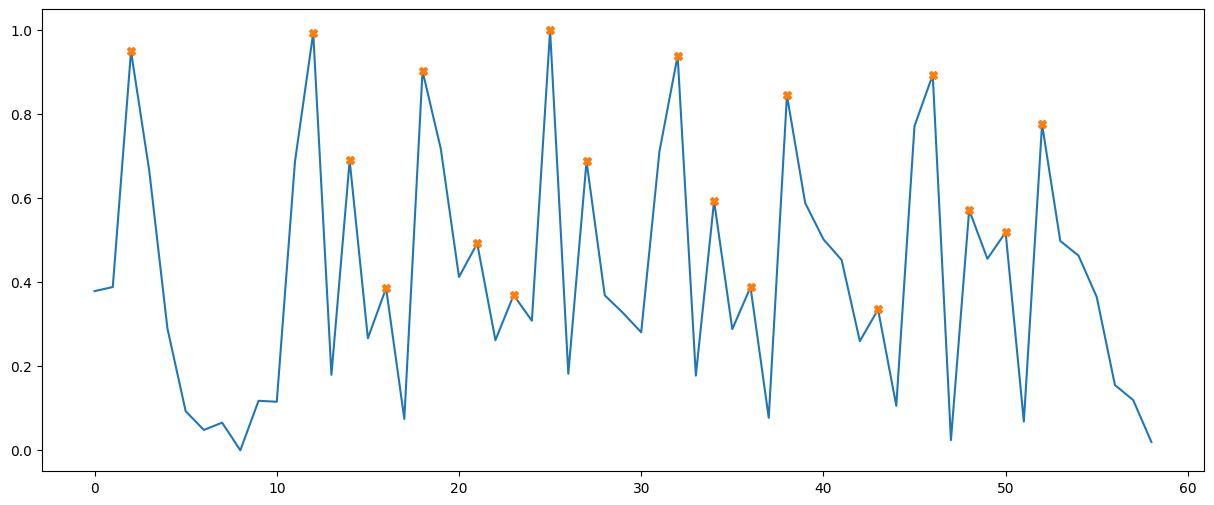

In [13]:
PEAKS_HEIGHT = 0.3
PEAKS_PROMINENCE = 0.0001

peaks, _ = find_peaks(scaled_diff, height=PEAKS_HEIGHT, prominence=PEAKS_PROMINENCE)

plt.figure(figsize=(15, 6))
plt.plot(scaled_diff)
plt.plot(peaks, scaled_diff[peaks], "X")

Peaks found in downsampled signal: [ 2 12 14 16 18 21 23 25 27 32 34 36 38 43 46 48 50 52]
Peaks in real signal: [  800  4800  5600  6400  7200  8400  9200 10000 10800 12800 13600 14400
 15200 17200 18400 19200 20000 20800]


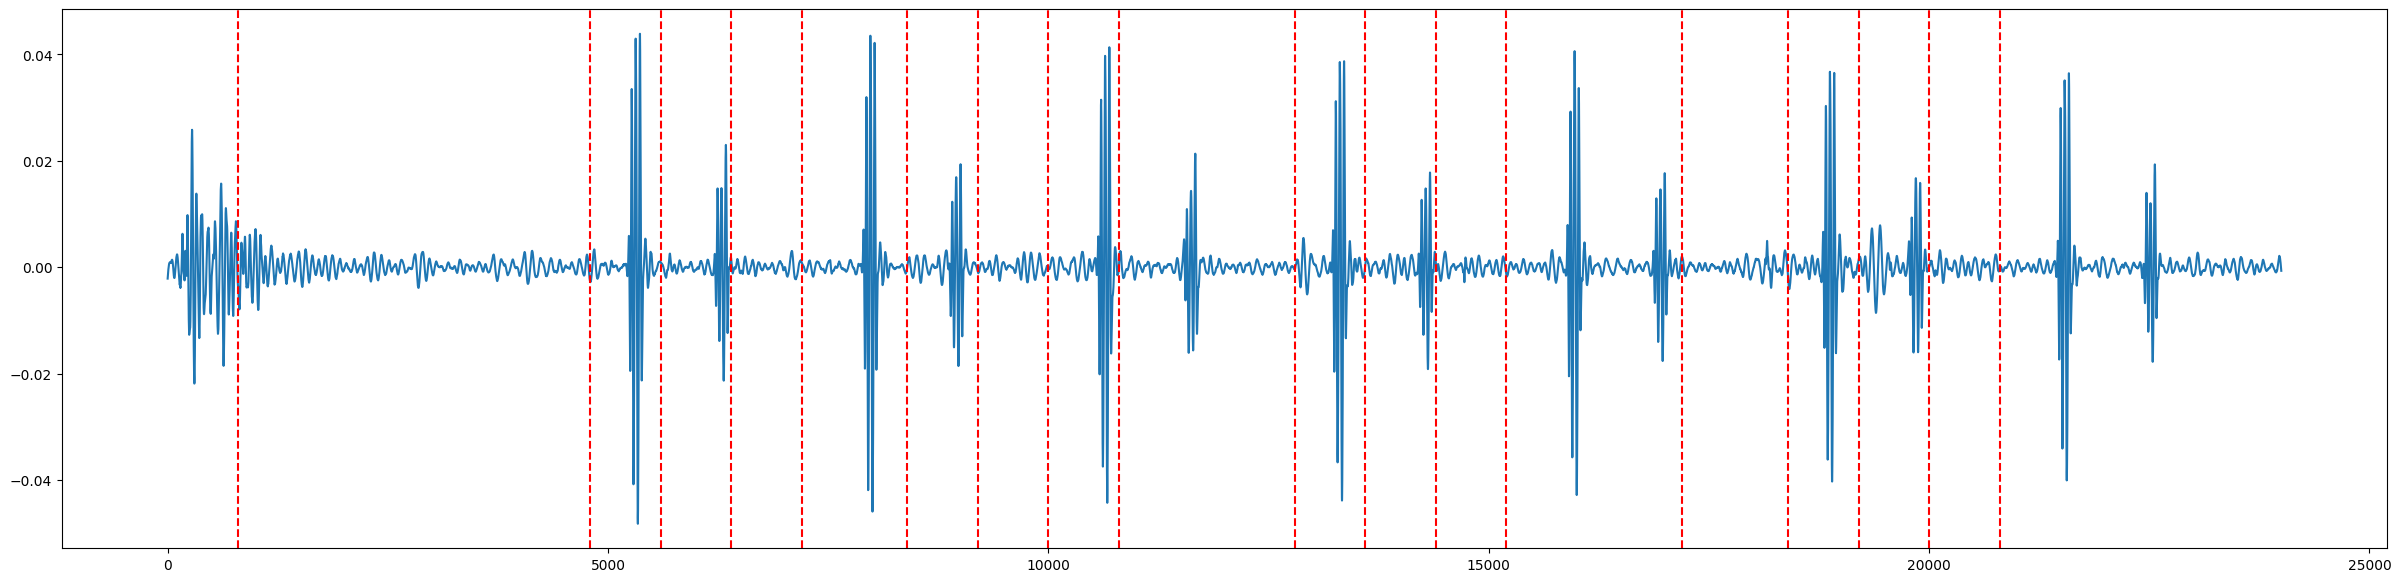

In [14]:
upsampled_peaks = peaks * DOWNSAMPLE_FACTOR
print(f"Peaks found in downsampled signal: {peaks}")
print(f"Peaks in real signal: {upsampled_peaks}")

plt.figure(figsize=(30, 7))
plt.plot(snippet.squeeze())

for peak in upsampled_peaks:
    plt.axvline(x=peak, color="red", linestyle="--")

plt.show()